In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import os
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
from keras.optimizers import *
import keras
import pandas_datareader.data as web
import h5py
from keras import backend as K

Using TensorFlow backend.


In [2]:

def moving_average(group, n,center=False):
    sma = pd.Series.rolling(group, window=n,center=center).mean()
    return sma

def bollinger_mid(group):
    boll = pd.Series.rolling(group, window=20, center=False).mean()
    return boll

def exponential_moving_average(group, span,min_periods=1, ignore_na=False):
    ema = pd.Series.ewm(group, min_periods=min_periods, adjust=True, span=span, ignore_na=ignore_na).mean()
    return ema

def moving_average_convergence(group, nslow=26, nfast=12):
    emaslow = exponential_moving_average(group, nslow, 1)
    emafast = exponential_moving_average(group, nfast, 1)
    macd = emafast-emaslow
    return macd

def CCI(close, high, low, n=20, constant=0.015):
    TP = (high + low + close) / 3
    CCI = pd.Series((TP - pd.Series.rolling(TP, center=False,window=n).mean()) / (constant * pd.Series.rolling(TP,center=False,window=n).std()), name = 'CCI_' + str(n))
    return CCI

def ATR(df):
    df['ATR1'] = abs (df['high'] - df['low'])
    df['ATR2'] = abs (df['high'] - df['close'].shift())
    df['ATR3'] = abs (df['low'] - df['close'].shift())
    atr = df[['ATR1', 'ATR2', 'ATR3']].max(axis=1)
    return atr

def get_stock_data(stock_name, normalize=True, ma=[], macd=True, cci=True, atr=True, ema=[], bolling=True):
    df = pd.read_csv('stockdatas/{}.csv'.format(stock_name))

    df.set_index('date', inplace=True)

    # Percentage change
    df['Pct'] = df['adjClose'].pct_change()
    df.dropna(inplace=True)

    # Moving Average
    if ma != []:
        for x in ma:
            df['{}MA'.format(x)] = moving_average(df['adjClose'], x)
    if cci:
        df['CCI'] = CCI(df['close'], df['high'], df['low'])
    if macd:
        df['MACD'] = moving_average_convergence(df['adjClose'])
    if atr:
        df['ATR'] = ATR(df)
    if ema != []:
        for y in ema:
            df['{}EMA'.format(y)] = exponential_moving_average(df['adjClose'], span=x)
    if bolling:
        df['bolling'] = bollinger_mid(df['adjClose'])

    df.dropna(inplace=True)
    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler()
        df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1, 1))
        df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1, 1))
        df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1, 1))
        df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1, 1))
        df['adjClose'] = min_max_scaler.fit_transform(df['adjClose'].values.reshape(-1, 1))
        df['Pct'] = min_max_scaler.fit_transform(df['Pct'].values.reshape(-1, 1))
        if ma != []:
            for x in ma:
                df['{}MA'.format(x)] = min_max_scaler.fit_transform(
                    df['{}MA'.format(x)].values.reshape(-1, 1))
        if ema != []:
            for y in ema:
                df['{}EMA'.format(y)] = min_max_scaler.fit_transform(
                    df['{}EMA'.format(y)].values.reshape(-1, 1))
        if cci:
            min_max_scaler.fit_transform(df['CCI'].values.reshape(-1, 1))
        if macd:
            min_max_scaler.fit_transform(df['MACD'].values.reshape(-1, 1))
        if atr:
            min_max_scaler.fit_transform(df['ATR'].values.reshape(-1, 1))
        if bolling:
            min_max_scaler.fit_transform(df['bolling'].values.reshape(-1, 1))

    # move adj close to the rightmost
    adj_close = df['adjClose']
    df.drop(labels=['adjClose'], axis=1, inplace=True)
    df = pd.concat([df, adj_close], axis=1)
    return df

def plot_stock(df):
    print(df.head())
    plt.subplot(211)
    plt.plot(df['adjClose'], color='red', label='Adj Close')
    plt.legend(loc='best')
    plt.subplot(212)
    plt.plot(df['pct'], color='blue', label='Percentage change')
    plt.legend(loc='best')
    plt.show()

def check_corr(df):
    corr = df.corr()
    ax = sns.heatmap(corr, cmap="BuGnYl")
    plt.show()

def build_dataset(stock, seq_len, ratio=0.8):
    num_of_features = len(stock.columns)
    print("Number of features = {}".format(num_of_features))
    data = stock.as_matrix()
    sequence_length = seq_len + 1
    result = []

    for idx in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[idx: idx + sequence_length]) # index : index + 22days

    result = np.array(result)
    row = round(ratio * result.shape[0])
    print ("Total of training data = {}".format(ratio * result.shape[0]))
    print ("Total of testing data = {}".format(abs(1.0-ratio) * result.shape[0]))

    train = result[:int(row), :]
    X_train = train[:, :-1] # all data until day m
    y_train = train[:, -1][:,-1] # day m + 1 adjusted close price

    X_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], num_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], num_of_features))

    return [X_train, y_train, X_test, y_test]

def build_model(shape, neurons, dropout, optimizer, learning_rate, decay):
    model = Sequential()

    model.add(LSTM(neurons[0], input_shape=(shape[0], shape[1]), return_sequences=True))
    model.add(Dropout(dropout))

    model.add(LSTM(neurons[1], input_shape=(shape[0], shape[1]), return_sequences=False))
    model.add(Dropout(dropout))

    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))

    opt = optimizer(lr=learning_rate, decay=decay)
    model.compile(loss='mse',optimizer=opt, metrics=['accuracy'])
    model.summary()
    return model

# Result
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

def percentage_difference(model, X_test, y_test):
    percentage_diff=[]

    p = model.predict(X_test)
    for u in range(len(y_test)): # for each data index in test data
        pr = p[u][0] # pr = prediction on day u

        percentage_diff.append((pr-y_test[u]/pr)*100)
    return p


def denormalize(stock_name, normalized_value):
    df = pd.read_csv('stockdatas/{}.csv'.format(stock_name))
    #df.drop(['open','high','low','close','volume'], 1, inplace=True)
    df.set_index('date', inplace=True)

    df.dropna(inplace=True)
    df = df['adjClose'].values.reshape(-1, 1)
    normalized_value = normalized_value.reshape(-1, 1)

    # return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)

    return new

def plot_result(stock_name, normalized_value_p, normalized_value_y_test):
    newp = denormalize(stock_name, normalized_value_p)
    newy_test = denormalize(stock_name, normalized_value_y_test)
    plt2.plot(newp, color='red', label='Prediction')
    plt2.plot(newy_test,color='blue', label='Actual')
    plt2.legend(loc='best')
    plt2.title('The test result for {}'.format(stock_name))
    plt2.xlabel('Days')
    plt2.ylabel('Adjusted Close')
    plt2.show()

In [3]:
# model configuration
seq_len = 22 # the window frame of the past data
num_of_features = 17
shape = [seq_len, num_of_features, 1]
neurons = [256, 256, 32, 1]
dropout = 0.3
optimizer = Adam
learning_rate = 0.01
decay = 0.5
epochs = 90
stock_name = 'AAPL'

df = get_stock_data(stock_name, ma=[5,10], ema=[20])

/home/ros/anaconda3/envs/research/lib/python3.5/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [4]:
X_train, y_train, X_test, y_test = build_dataset(df, seq_len)

Number of features = 17
Total of training data = 3533.6000000000004
Total of testing data = 883.3999999999997


In [5]:
model = build_model(shape, neurons, dropout, optimizer, learning_rate, decay)
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=epochs,
    validation_split=0.2,
    verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 22, 256)           280576    
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 814,145
Trainable params: 814,145
Non-trainable params: 0
_________________________________________________________________
Trai

2827/2827 [==============================] - 3s - loss: 9.5309e-05 - acc: 3.5373e-04 - val_loss: 0.0199 - val_acc: 0.0000e+00
Epoch 53/90
2827/2827 [==============================] - 3s - loss: 9.9141e-05 - acc: 3.5373e-04 - val_loss: 0.0202 - val_acc: 0.0000e+00
Epoch 54/90
2827/2827 [==============================] - 3s - loss: 1.0116e-04 - acc: 3.5373e-04 - val_loss: 0.0204 - val_acc: 0.0000e+00
Epoch 55/90
2827/2827 [==============================] - 3s - loss: 9.3645e-05 - acc: 3.5373e-04 - val_loss: 0.0200 - val_acc: 0.0000e+00
Epoch 56/90
2827/2827 [==============================] - 4s - loss: 1.0412e-04 - acc: 3.5373e-04 - val_loss: 0.0201 - val_acc: 0.0000e+00
Epoch 57/90
2827/2827 [==============================] - 3s - loss: 9.5217e-05 - acc: 3.5373e-04 - val_loss: 0.0201 - val_acc: 0.0000e+00
Epoch 58/90
2827/2827 [==============================] - 3s - loss: 9.7448e-05 - acc: 3.5373e-04 - val_loss: 0.0198 - val_acc: 0.0000e+00
Epoch 59/90
2827/2827 [=======================

Train Score: 0.00408 MSE (0.06 RMSE)
Test Score: 0.32784 MSE (0.57 RMSE)


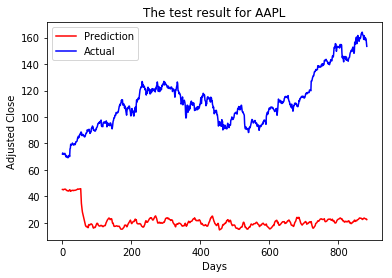

In [6]:
model_score(model, X_train, y_train, X_test, y_test)
p = percentage_difference(model, X_test, y_test)
plot_result(stock_name, p, y_test)